# Enhanced Anomaly Detection using Variational Autoencoder

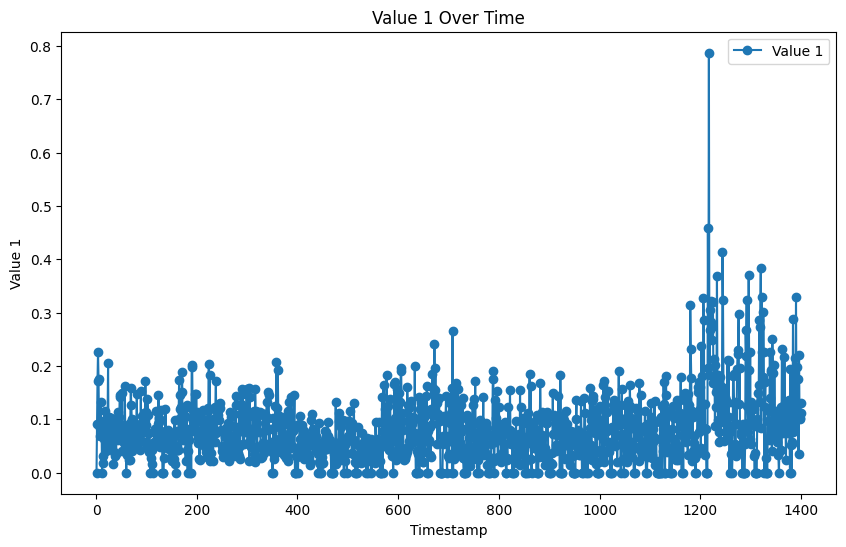

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Load and visualize the data from CSV file
data = pd.read_csv('yahoo_sub_5.csv')

def plot_value_1(data):
    plt.figure(figsize=(10, 6))
    plt.plot(data['timestamp'], data['value_1'], label='Value 1', marker='o')
    plt.xlabel('Timestamp')
    plt.ylabel('Value 1')
    plt.title('Value 1 Over Time')
    plt.legend()
    plt.show()

plot_value_1(data)

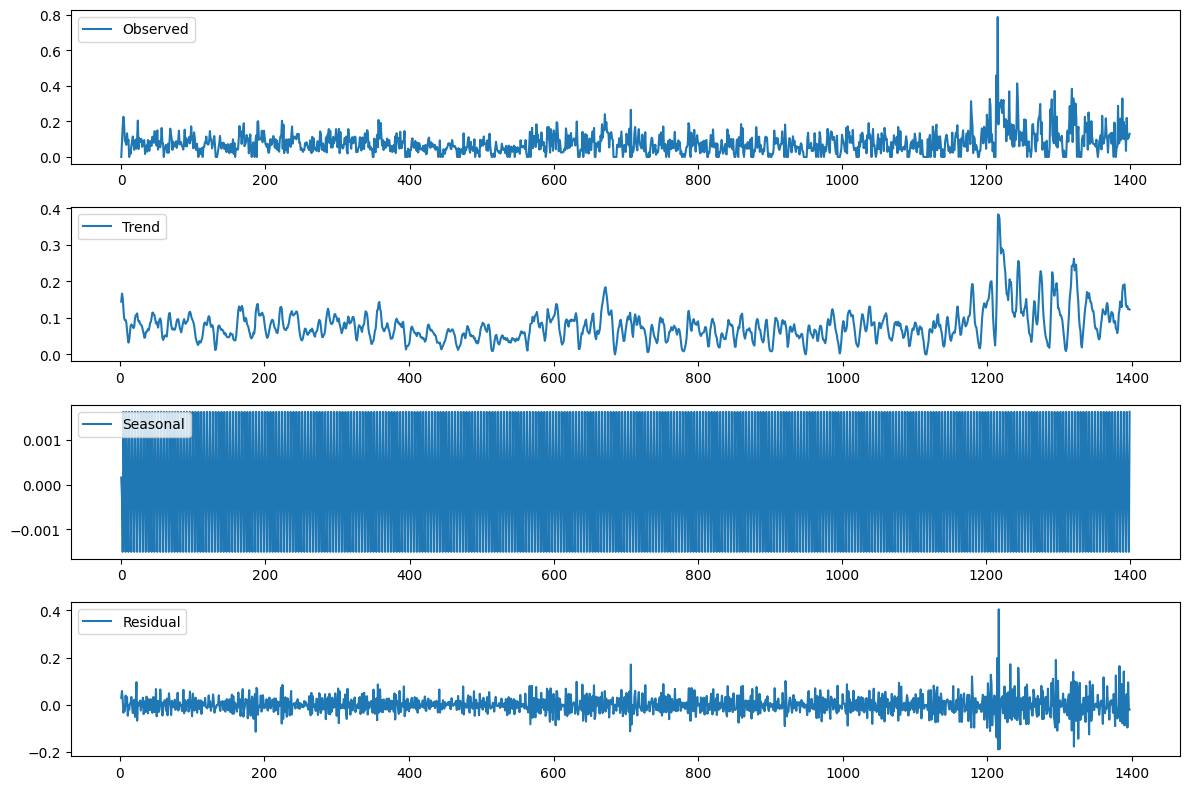

In [8]:
# Decompose time-series data
decompose_result = seasonal_decompose(data['value_1'], model='additive', period=4)

def plot_decomposition(decompose_result):
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decompose_result.observed, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decompose_result.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decompose_result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decompose_result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_decomposition(decompose_result)


In [3]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 16)
        self.fc3 = nn.Linear(16, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training the VAE
vae = VAE(input_dim=1, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 50

for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch in data_loader:
        batch = batch.unsqueeze(1)  # Adding feature dimension
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(data_loader.dataset):.4f}")

NameError: name 'data_loader' is not defined

In [ ]:
# Detect pointwise anomalies
vae.eval()
data_tensor = torch.tensor(values, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    recon, mu, logvar = vae(data_tensor)
    reconstruction_error = torch.abs(recon - data_tensor).numpy()

threshold = np.percentile(reconstruction_error, 95)
anomalies_pointwise = reconstruction_error > threshold

# Plot pointwise anomalies
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['value_1'], label='Value 1')
plt.scatter(data['timestamp'][anomalies_pointwise.flatten()], data['value_1'][anomalies_pointwise.flatten()], color='red', label='Pointwise Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value 1')
plt.title('Pointwise Anomalies Detected by VAE')
plt.legend()
plt.show()

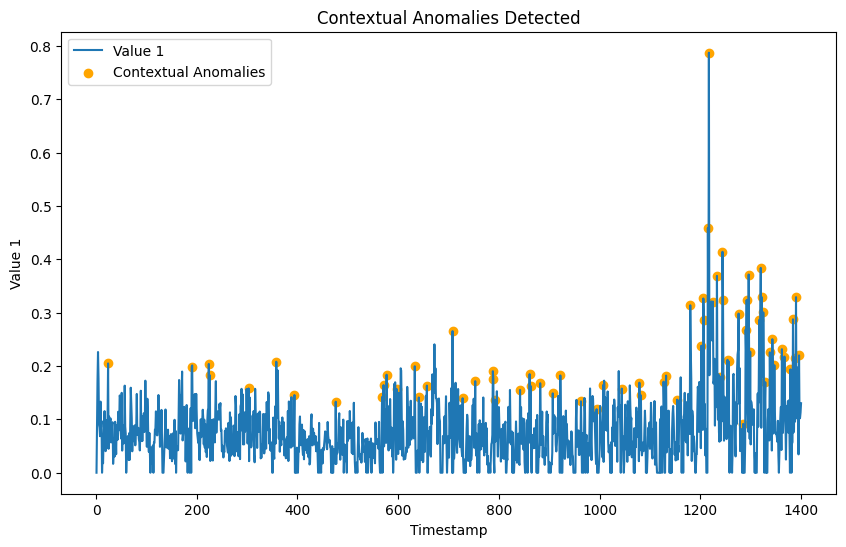

In [4]:
contextual_threshold = np.percentile(decompose_result.resid.dropna(), 95)
anomalies_contextual = decompose_result.resid > contextual_threshold

# Extract anomaly indices
anomaly_indices = anomalies_contextual[anomalies_contextual].index

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['value_1'], label='Value 1')
plt.scatter(data.loc[anomaly_indices, 'timestamp'], data.loc[anomaly_indices, 'value_1'], color='orange', label='Contextual Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value 1')
plt.title('Contextual Anomalies Detected')
plt.legend()
plt.show()

In [ ]:
autencoder more layerrs 
convolotional laers 
window_size 



In [5]:
# Compute collective reconstruction error
collective_reconstruction_error = []
for i in range(len(values) - window_size + 1):
    # Extract true window from the original data
    true_window = np.array(values[i:i + window_size])  # Ensure it's a NumPy array
    
    # Extract reconstructed window from the VAE output
    recon_window = recon.flatten()[i:i + window_size].detach().cpu().numpy()  # Convert to NumPy array
    
    # Calculate the average error over the window
    error = np.mean(np.abs(true_window - recon_window))
    collective_reconstruction_error.append(error)

# Define a threshold for collective anomaly detection
threshold_collective = np.mean(collective_reconstruction_error) + 2 * np.std(collective_reconstruction_error)

# Extend reconstruction error to match data length (pad with NaNs)
collective_reconstruction_error = [np.nan] * (window_size - 1) + collective_reconstruction_error

# Mark collective anomalies in the data
data['collective_anomaly'] = [
    1 if error > threshold_collective else 0
    for error in collective_reconstruction_error
]

# Visualize data with collective anomalies
plt.figure(figsize=(14, 7))
plt.plot(data['timestamp'], data['value_1'], label='Original Data', color='blue')

# Highlight collective anomalies (entire windows as a group)
for i in range(len(data) - window_size + 1):
    if data['collective_anomaly'].iloc[i]:
        plt.plot(
            data['timestamp'].iloc[i:i + window_size],
            data['value_1'].iloc[i:i + window_size],
            color='red', linewidth=2.5, label='Collective Anomaly' if i == 0 else "", zorder=5
        )

plt.title('VAE-based Collective Anomaly Detection')
plt.xlabel('Timestamp')
plt.ylabel('Value 1')
plt.legend()
plt.show()


NameError: name 'values' is not defined

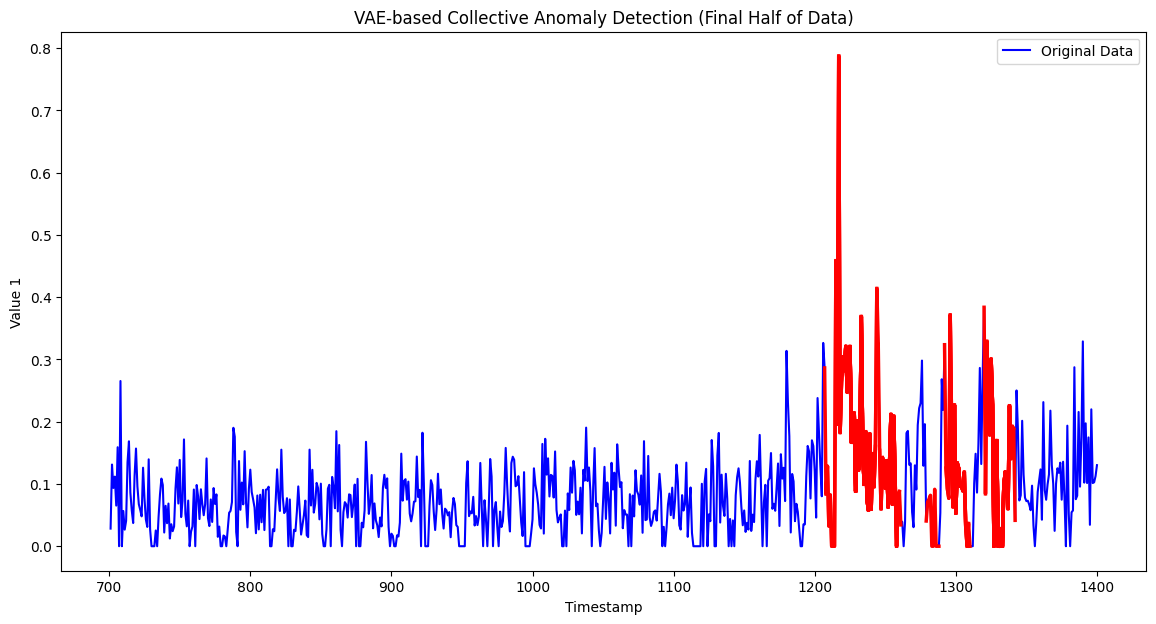

In [37]:
# Extract the final half of the data
half_index = len(data) // 2
final_half_data = data.iloc[half_index:].copy()

# Subset the reconstruction error for the final half
final_half_reconstruction_error = collective_reconstruction_error[half_index:]

# Update collective anomalies for the final half
final_half_data['collective_anomaly'] = [
    1 if error > threshold_collective else 0
    for error in final_half_reconstruction_error
]

# Plot the final half with collective anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(final_half_data['timestamp'], final_half_data['value_1'], label='Original Data', color='blue')

# Highlight collective anomalies in the final half
for i in range(len(final_half_data) - window_size + 1):
    if final_half_data['collective_anomaly'].iloc[i]:
        plt.plot(
            final_half_data['timestamp'].iloc[i:i + window_size],
            final_half_data['value_1'].iloc[i:i + window_size],
            color='red', linewidth=2.5, label='Collective Anomaly' if i == 0 else "", zorder=5
        )

plt.title('VAE-based Collective Anomaly Detection (Final Half of Data)')
plt.xlabel('Timestamp')
plt.ylabel('Value 1')
plt.legend()
plt.show()


In [6]:
# Extract data from the 1200th row to the end
start_index = 1200
subset_data = data.iloc[start_index:].copy()

# Subset the reconstruction error to match the new range
subset_reconstruction_error = collective_reconstruction_error[start_index:]

# Update collective anomalies for the subset data
subset_data['collective_anomaly'] = [
    1 if error > threshold_collective else 0
    for error in subset_reconstruction_error
]

# Plot the subset data with collective anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(subset_data['timestamp'], subset_data['value_1'], label='Original Data', color='blue')

# Highlight collective anomalies in the subset
for i in range(len(subset_data) - window_size + 1):
    if subset_data['collective_anomaly'].iloc[i]:
        plt.plot(
            subset_data['timestamp'].iloc[i:i + window_size],
            subset_data['value_1'].iloc[i:i + window_size],
            color='red', linewidth=2.5, label='Collective Anomaly' if i == 0 else "", zorder=5
        )

plt.title('VAE-based Collective Anomaly Detection (Rows 1200 to End)')
plt.xlabel('Timestamp')
plt.ylabel('Value 1')
plt.legend()
plt.show()


ValueError: Length of values (0) does not match length of index (200)